# 前提条件

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls
%cd '/content/drive/MyDrive/Colab Notebooks/face_recognition'
!ls

drive  sample_data
/content/drive/MyDrive/Colab Notebooks/face_recognition
aedl_embedding.npz  facenet_keras.h5	    known_faces
aedl.npz	    face_recognition.ipynb  unknown_faces


In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.0 MB/s 


In [4]:
from keras.models import load_model
#import tensorflow as tf
#from tensorflow import convert_to_tensor
import mtcnn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from numpy import asarray, savez_compressed, load, expand_dims
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from random import choice

In [5]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # 学習曲線をプロットする
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# データ処理

In [6]:
detector = MTCNN()

def crop_face_x(pixels,results):
  # pixels: numpy array
  pixels = asarray(pixels)
  x1, y1, w, h = results[0]['box']
  x1 = x1 - w*0.1 if x1 - w*0.1 > 0 else 0
  y1 = y1 - h*0.1 if y1 - h*0.1 > 0 else 0
  x2 = x1 + w*1.2 if x1 + w*1.2 < pixels.shape[1] else pixels.shape[1]
  y2 = y1 + h*1.2 if y1 + w*1.2 < pixels.shape[0] else pixels.shape[0]
  
  face = pixels[int(y1):int(y2), int(x1):int(x2)]
  return face
def face_extract (filename, required_size=(160,160)):
  image = Image.open(filename)
  
  image = image.convert('RGB')
  
  #nparrayに変換 
  pixels = asarray(image)
  pixels_flip = np.array(image.transpose(method=Image.FLIP_LEFT_RIGHT)) #フリップ
  pixels_top = np.array(image.transpose(method=Image.FLIP_TOP_BOTTOM))
  pixels_rotate_180 = np.array(image.transpose(method=Image.ROTATE_180)) #回転する
  pixels_rotate_90 = np.array(image.transpose(method=Image.ROTATE_90))
  pixels_rotate_270 = np.array(image.transpose(method=Image.ROTATE_270))
  pixels_transpose = np.array(image.transpose(method=Image.TRANSPOSE)) #転置
  pixels_transverse = np.array(image.transpose(method=Image.TRANSVERSE)) #トランスバース

  results = detector.detect_faces(pixels)
  results_flip = detector.detect_faces(pixels_flip)
  results_top = detector.detect_faces(pixels_top)
  results_180 = detector.detect_faces(pixels_rotate_180)
  results_90 = detector.detect_faces(pixels_rotate_90)
  results_270 = detector.detect_faces(pixels_rotate_270)
  results_transpose = detector.detect_faces(pixels_transpose)
  results_transverse = detector.detect_faces(pixels_transverse)

  # boxとbox_flipに基づいて顔をトリミングし、取得した各顔をface_arrayに追加します
  face_array = []
  if results:
    face = crop_face_x(pixels,results)
    # サイズを変更してface_arrayにface_flipを追加します
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array.append(asarray(image))
    
  if results_flip:
    face_flip = crop_face_x(pixels_flip,results_flip)
    #サイズを変更してface_arrayにface_flipを追加します 
    image = Image.fromarray(face_flip)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_top:
    face_top = crop_face_x(pixels_top,results_top)
    # サイズを変更してface_arrayにface_flipを追加します  
    image = Image.fromarray(face_top)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_180:
    face_180 = crop_face_x(pixels_rotate_180,results_180)
    # サイズを変更してface_arrayにface_flipを追加します  
    image = Image.fromarray(face_180)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_90:
    face_90 = crop_face_x(pixels_rotate_90,results_90)
    # サイズを変更してface_arrayにface_flipを追加します  
    image = Image.fromarray(face_90)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_270:
    face_270 = crop_face_x(pixels_rotate_270,results_270)
    # サイズを変更してface_arrayにface_flipを追加します  
    image = Image.fromarray(face_270)
    image = image.resize(required_size)
    face_array.append(asarray(image))
  
  if results_transpose:
    face_transpose = crop_face_x(pixels_transpose,results_transpose)
    # サイズを変更してface_arrayにface_flipを追加します  
    image = Image.fromarray(face_transpose)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_transverse:
    face_transverse = crop_face_x(pixels_transverse,results_transverse)
    # サイズを変更してface_arrayにface_flipを追加します  
    image = Image.fromarray(face_transverse)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  return face_array

In [7]:
def load_faces(dir):
  faces = list()
  for filename in listdir(dir):
    path = dir+filename
    face = face_extract(path)
    
    faces.extend(face)

  return faces

In [8]:
#load faces and label
def load_data(dir):
  X,y = list(),list()
  for subdir in listdir(dir):
    path = dir + subdir + '/'
    if not isdir(path):
      continue
    faces = load_faces(path)
    #create labels
    labels = [subdir for _ in range(len(faces))]
    #progress tracker
    print('>>loaded {} examples from class: {}'.format(len(faces), subdir))
    X.extend(faces)
    y.extend(labels)
  return asarray(X), asarray(y)

In [9]:
def do_embedding(face_pixels, model):
  # 前処理、標準化
  face_pixels = face_pixels.astype('float32')
  fmean, fstd = face_pixels.mean(), face_pixels.std()
  face_pixels = (face_pixels-fmean)/fstd
  samples = expand_dims(face_pixels, axis=0) 
  y_hat = model.predict(samples)             
  embedding = y_hat[0]                       

  return embedding

In [10]:
train_folder = 'known_faces/'
X, y = load_data(train_folder)
print(X.shape, y.shape)

>>loaded 350 examples from class: ishihara_satomi
>>loaded 618 examples from class: phuong
>>loaded 726 examples from class: Son_Tung
>>loaded 422 examples from class: taylor_swift
(2116, 160, 160, 3) (2116,)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train : 学習用特徴行列 (80%)
#X_val : 評価用特徴行列 (20%)
#y_train : 学習用クラスラベル (80%) 未知のデータ
#y_val : 評価用クラスラベル (20%)　未知のデータの答え合わせに使う (隠し持っておく)

In [13]:
savez_compressed('aedl.npz', X_train, y_train, X_val, y_val)

In [14]:
data = load('aedl.npz', allow_pickle=True)
X_train, y_train, X_val, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Loaded:  (1692, 160, 160, 3) (1692,) (424, 160, 160, 3) (424,)


In [15]:
#Load facenet model
model_facenet = load_model('facenet_keras.h5', compile = False)
print('Model loaded')

Model loaded


In [16]:
# model network
model_facenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [17]:
X_train_new = list()
for face_pixels in X_train:
  embedding = do_embedding(face_pixels, model_facenet)
  X_train_new.append(embedding)

X_train_new = asarray(X_train_new)
print(X_train_new.shape)

(1692, 128)


In [18]:
X_val_new = list()
for face_pixels in X_val:
  embedding = do_embedding(face_pixels, model_facenet)
  X_val_new.append(embedding)

X_val_new = asarray(X_val_new)
print(X_val_new.shape)

(424, 128)


In [19]:
savez_compressed('aedl_embedding.npz', X_train_new, y_train, X_val_new, y_val)

In [20]:
data = load('aedl_embedding.npz')
X_train, y_train, X_val, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, val=%d' % (X_train.shape[0], X_val.shape[0]))

Dataset: train=1692, val=424


In [21]:
#入力ベクトルX_trainとX_valを正規化する
#正規化方法の定義：l2
in_encoder = Normalizer(norm='l2') 
#正規化
X_train = in_encoder.transform(X_train)
X_val = in_encoder.transform(X_val)
print(X_train)
print(X_val)

[[ 0.0522036  -0.040562   -0.09546405 ... -0.21614343 -0.01407327
  -0.1113162 ]
 [-0.05486724 -0.07803944 -0.04038355 ...  0.03177777  0.11367878
  -0.01576939]
 [ 0.10681754 -0.06908307  0.0186156  ... -0.11017161  0.00846385
  -0.11857899]
 ...
 [-0.1137768  -0.10869952 -0.02071824 ... -0.07742199  0.113355
   0.15919134]
 [-0.04720346 -0.13682105  0.06890157 ... -0.09060282  0.04951173
   0.0818751 ]
 [ 0.10858808 -0.07106112  0.03290648 ... -0.11501886  0.00728736
  -0.0512154 ]]
[[ 0.0626474   0.01003625 -0.03777881 ... -0.15628164 -0.04661971
  -0.05142669]
 [-0.05488297 -0.08075268 -0.06880712 ... -0.04798008  0.156403
   0.0507718 ]
 [-0.12254424 -0.0997009  -0.11103056 ... -0.07494073  0.20096852
   0.06594077]
 ...
 [ 0.02499226 -0.2094054   0.03856741 ... -0.09541474 -0.07339543
  -0.05658242]
 [-0.12292963 -0.02665216  0.06805633 ... -0.02627285  0.08833721
   0.18909441]
 [-0.00313769 -0.02265098 -0.00069575 ... -0.06128105  0.01937196
  -0.02143717]]


In [22]:
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
print(y_train)
y_val = out_encoder.transform(y_val) 
print(y_val)

[0 1 2 ... 0 0 2]
[0 0 1 2 0 2 0 2 2 0 0 2 0 3 2 2 0 2 3 3 2 0 0 2 0 2 0 0 3 1 1 3 1 3 3 2 0
 0 0 2 2 3 1 1 0 2 3 2 3 3 2 0 3 1 0 1 0 1 3 1 2 3 2 0 3 0 3 3 2 3 1 2 1 0
 2 3 3 2 2 2 1 2 3 0 3 3 3 2 0 0 0 3 1 1 2 2 2 0 2 0 1 3 0 3 0 3 0 3 3 2 2
 0 1 0 0 0 2 2 1 3 1 0 2 0 3 3 2 0 3 1 3 3 0 2 1 0 0 2 2 1 0 0 0 2 3 3 1 3
 3 2 0 1 3 0 1 0 1 1 2 3 3 2 0 1 3 2 0 2 0 0 3 2 2 1 2 0 2 0 1 2 2 1 3 1 3
 2 3 1 2 1 2 2 3 0 0 3 2 1 2 1 3 2 0 0 3 3 1 3 2 2 0 1 0 0 0 0 2 3 2 0 0 3
 1 2 0 0 3 2 1 2 3 0 1 1 0 1 3 2 0 2 0 3 0 2 0 3 0 3 1 2 0 3 1 2 0 3 0 2 3
 2 3 3 3 2 0 0 2 2 3 2 0 3 3 0 1 0 3 1 2 0 2 1 0 0 3 3 0 2 2 2 2 2 0 2 0 3
 2 0 3 2 0 0 0 2 0 0 0 2 0 3 3 2 2 0 1 2 2 0 0 3 0 0 3 2 2 3 2 3 0 1 2 1 1
 1 1 2 0 2 0 3 2 1 2 3 0 3 0 3 0 0 2 0 0 2 1 2 2 2 2 3 1 0 3 0 2 0 3 0 0 2
 2 0 0 2 2 1 2 0 2 2 3 1 0 1 2 0 1 2 2 3 2 2 1 1 3 0 2 3 1 2 2 3 1 2 3 0 0
 0 2 0 1 0 3 2 3 0 2 3 2 2 1 2 3 0]


# トレーニング

In [23]:
from sklearn.svm import SVC

In [24]:
model_SVC = SVC(kernel = 'linear', probability=True, tol=1e-3, cache_size=200, max_iter=-1)

In [25]:
model = model_SVC
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [26]:
model = model_SVC

y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)
score_train = accuracy_score(y_train, y_hat_train)
score_val = accuracy_score(y_val, y_hat_val)
print('Support Vector Classification: Accuracy: train=%.3f, val=%.3f'%(score_train, score_val))

Support Vector Classification: Accuracy: train=0.901, val=0.880


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

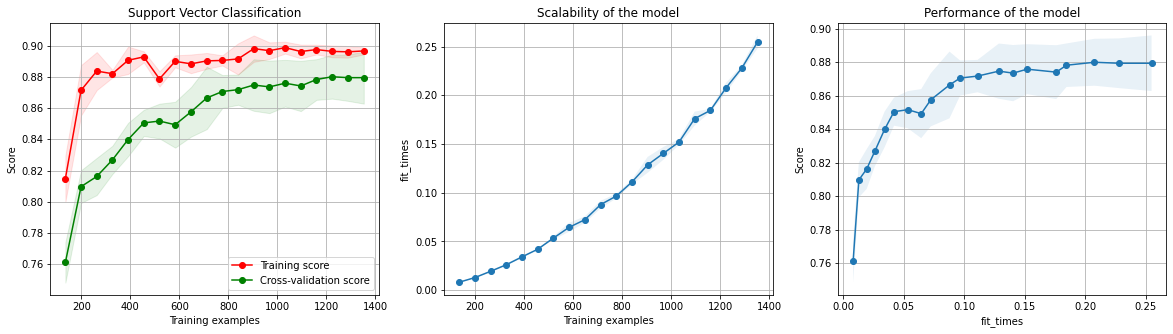

In [28]:
title="SVC"
plot_learning_curve(estimator=model_SVC, title="Support Vector Classification", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20))

# テスト

In [29]:
data = load('aedl.npz')
X_val_faces = data['arr_2']

model.fit(X_train, y_train)
for selection in range (X_val.shape[0]):
  random_face_pixels = X_val_faces[selection]
  random_face_embedding = X_val[selection]
 
  samples = expand_dims(random_face_embedding, axis = 0)
  y_hat_class = model.predict(samples)
  y_hat_prob = model.predict_proba(samples)
  class_index = y_hat_class[0]
  class_probability = y_hat_prob[0, class_index]
  predict_names = out_encoder.inverse_transform(y_hat_class)
  print('Predicted:')
  #  %s (%3f)'%(predict_names[0], class_probability))
  plt.imshow(random_face_pixels)
  title = '%s (%.3f)'%(predict_names[0], class_probability)
  plt.title(title)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [30]:
test_folder = 'unknown_faces/'
X_test = list()
X_test.extend(load_faces(test_folder))
X_test = asarray(X_test)
X_test_faces = X_test
print(X_test.shape)

X_test_new = list()
for face_pixels in X_test:
  embedding = do_embedding(face_pixels, model_facenet)
  X_test_new.append(embedding)

X_test = asarray(X_test_new)
X_test = in_encoder.transform(X_test)

print(X_test)

(74, 160, 160, 3)
[[ 0.15048723 -0.06425789  0.03104794 ... -0.04171056 -0.11821696
   0.16123083]
 [ 0.19530563 -0.01738564 -0.01250024 ... -0.04999058 -0.10927666
   0.15095977]
 [-0.08527564 -0.12959361  0.07812641 ... -0.01492654  0.05665757
   0.0505395 ]
 ...
 [ 0.06888274  0.02070406 -0.01351333 ...  0.06406043  0.10397515
   0.1739662 ]
 [-0.00106818 -0.04838531 -0.021988   ... -0.08234499  0.02995574
  -0.04135212]
 [ 0.03571045 -0.02228506  0.09342119 ...  0.03703298 -0.02437666
  -0.0421997 ]]


In [32]:
for i in range (X_test.shape[0]):
  face_pixels = X_test_faces[i]
  face_embedding = X_test[i]

  samples = expand_dims(face_embedding, axis = 0)
  y_hat_class = model.predict(samples)
  y_hat_prob = model.predict_proba(samples)

  class_index = y_hat_class[0]
  class_probability = y_hat_prob[0, class_index]
  # print(class_probability)

  predict_names = out_encoder.inverse_transform(y_hat_class)

  if class_probability < 0.5:
    print(print('Predicted: unknown. Closest prediction: %s (%3f)'%(predict_names[0], class_probability)))
    title = 'Unknown'
  else:
    print('Predicted: ')
    #  %s (%3f)'%(predict_names[0], class_probability))
    title = '%s (%.3f)'%(predict_names[0], class_probability)
  # print('Expected: %s'%random_face_name[0])
  plt.imshow(face_pixels)
  # title = '%s (%.3f)'%(predict_names[0], class_probability)
  plt.title(title)
  plt.show()
    

Output hidden; open in https://colab.research.google.com to view.